In [1]:
%matplotlib inline

In [2]:
import sys, glob
from astropy.table import Table

## Python package needed

Assume you already has basic pakcages such as, numpy, matplotlib, 
FrEIA is included in cINN_SSP pakcage. But to run FrEIA, you need 
- pytorch (https://pytorch.org/get-started/locally/)
- there are other pakcages required for FrEIA (e.g. torchvision, pdoc, visdom), but you may not need those for now...

Additionally, 
- KDEpy (https://kdepy.readthedocs.io/en/latest/index.html): for MAP calculation used in expander.py

# How to use  a triained cINN using cINN_SSP package

You can use networks in any working directory if you add path to cINN_SSP
> sys.path.append("/PATH/TO/CINNSSP/cINN_SSP")

In [3]:
cwd = os.getcwd()
print(cwd)

/Users/daeun/Dropbox/Astronomy/Pj_cinn_ssp/cINN_SSP/examples


In [4]:
# Add cINN_SSP to your path
sys.path.append("/Users/daeun/Astronomy/Pj_cinn_ssp/cINN_SSP/")

## Read the network using cINNConfig class (in cINN_config.py)
simply, you can read your network configuration by using 'read_config_from_file' function
> c = read_config_from_file( CONFIG_FILE_PATH, proj_dir=NET_DIR) 

This will return the 'cINNConfig' class variable that includes all information of your config.

First import read_config_from_file
> from cINN_set.cINN_config import read_config_from_file

In [5]:
from cINN_set.cINN_config import read_config_from_file

### How to set the path
> c = read_config_from_file( CONFIG_FILE_PATH, proj_dir=NET_DIR) 

CONFIG_FILE_PATH is the path to the config file.

The function will check NET_DIR+c.filename whether the network file exists.
Because the keyword *proj_dir* updates the path of filename and tablename in the config to
- proj_dir + filename
- proj_dir + tablename

filename and tablename can include upper directories. You'd better make your own network directory using this feature.

(tablename is the path to training database,DB. it is not used in this tutorial)

Let's say your network directory is NET_DIR and you have config files in NET_DIR/configs/ and network files in NET_DIR/models/.
In this case, your config file has a filename such as filename = models/XXXX.pt
You can read your configuration by
> c = read_config_from_file( NET_DIR/configs/config.py, proj_dir=NET_DIR)

it will find your network file at NET_DIR/models/XXXX.pt

## Read and Use Normal-Net (Settl-Net)
We will read a Settel network in networks/Stl_TGA_tpl/. 

There is config file 'c_Stl_TGA_tpl.py' and network file 'Stl_TGA_tpl.pt'.
Check the filename set in c_Stl_TGA_tpl.py 

In [6]:
net_dir = '../networks/Stl_TGA_tpl/'
config_file = 'c_Stl_TGA_tpl.py'

c = read_config_from_file( net_dir + config_file, proj_dir = net_dir)

All the configuration hyperparameters are saved as attribute of c.

In [7]:
print('c.filename:',c.filename)
print('c.config_file',c.config_file) # this is path to your config file: net_dir+config_file
c.print_short_setting()
print('c.device:',c.device) # which device you will use for the network: cpu or cuda (gpu)
print('c.prenoise_training:',c.prenoise_training) # if True it is Noise-Net, This network is Normal-Net so it is Falase
print('c.parameter_list:',c.parameter_list) # List of all hyperparameters. You can find the hyperparameter from this list

c.filename: ../networks/Stl_TGA_tpl/Stl_TGA_tpl.pt
c.config_file ../networks/Stl_TGA_tpl/c_Stl_TGA_tpl.py
==================== cINN NETWORK SETTING =================
cINN_config file: c_Stl_TGA_tpl.py
database: ecogal_spectra_ts_Settl_AV0to10.csv
# of parameters: 3
# of observables: 2930
device: cuda
c.device: cuda
c.prenoise_training: False
c.parameter_list: ['adam_betas', 'affine_clamping', 'batch_size', 'checkpoint_save', 'checkpoint_save_interval', 'checkpoint_save_overwrite', 'device', 'do_rev', 'exponent_clamping', 'feature_layer', 'feature_width', 'gamma', 'gin_block', 'global_affine_init', 'global_affine_type', 'init_scale', 'internal_layer', 'internal_width', 'l2_weight_reg', 'latent_noise', 'learned_householder_permutation', 'live_visualization', 'load_file', 'loss_names', 'loss_plot_xrange', 'loss_plot_yrange', 'lr_init', 'meta_epoch', 'n_blocks', 'n_epochs', 'n_its_per_epoch', 'permute_soft', 'pre_low_lr', 'progress_bar', 'reverse_permutation', 'seed_weight_init', 'use_perm

In [8]:
print('c.x_names:',c.x_names) # list of X (parameters to predict)
# print('c.y_names:',c.y_names) # list of Y (Obs. in our project this is too long...)

c.x_names: ['logTeff', 'logG', 'A_V']


!! This tutorial does not include how to use training databse (DB). DB is not uploaded in cINN_SSP because of its large volume.

## Read network and make prediction (Normal-Net)

before you use or read network file, you should check/modify c.device.

In [9]:
c.device

'cuda'

If you are not using CUDA GPU or MAC GPU, then always change c.device to "cpu" befor you use it.

In [10]:
# let's start again from reading config file (just in case if you changed something in previous cells)
net_dir = '../networks/Stl_TGA_tpl/'
config_file = 'c_Stl_TGA_tpl.py'

c = read_config_from_file( net_dir + config_file, proj_dir = net_dir)
c.device = 'cpu'
print(c.device)

cpu


### Load expander (expander.py in cINN_set). 
This includes various useful functions including posterior predciton and plotting. Either by
> exp = c.import_expander()

or 
> import cINN_set.expander as exp

In [11]:
exp = c.import_expander()

### Prepare observations

In [12]:
# Read example spectra in examples/Tr14_spec/. There are 3 spectra
# flux is in physical unit
spec_array = []
for file in sorted(glob.glob('Tr14_spec/*.dat')):
    spec_array.append(np.loadtxt(file))
spec_array = np.array(spec_array)

In [13]:
# 1) you need to reduce the dimension corresponding to the network (i.e. exluding emission lines)
#-------------------- Reduce observation/sigma dimension equal to y_names ----------------------------
y_table = Table(spec_array, names=['l{:d}'.format(i) for i in range(0, 3681)]) # MUSE full range
y_table = y_table[c.y_names]
obs_array = np.array(y_table).view(float).reshape(len(y_table), -1)

# [Suggestion]: if you use real data, you'd better avoid negative values (also, you must avoid nan values)
# for physical unit: clip to 0 flux
obs_array = np.clip(obs_array, a_min=0, a_max=None)

In [14]:
# 2) Normalize spectrum by the total flux
# because this network used normalized flux
print('c.normalize_flux:',c.normalize_flux)
print('c.normalize_total_flux:',c.normalize_total_flux)

# simply you can normalize flux by yourself
# > obs_array = obs_array/np.sum(obs_array, axis=1).reshape(-1,1) 

# or you can use exp
if c.normalize_flux:
    obs_array = exp.normalize_flux(obs_array, normalize_total_flux=c.normalize_total_flux, 
                       normalize_mean_flux=c.normalize_mean_flux, normalize_f750=c.normalize_f750)

c.normalize_flux: True
c.normalize_total_flux: True


### Make posterior distribution
Use exp.get_posterior function

argument: 
- observaiton (1D or 2D array)
- config 
- N : number of posterior estimates (recommened 4096)

This function will first load your network if it is not loaded yet. When loading the network, it will assign network model in designated device (= c.device).

In [15]:
post_list = exp.get_posterior(obs_array, c, N=4096) 

print(post_list.shape) # output dimension =  N(obs) x N_pred x N_param

(3, 4096, 3)


### additional calculation : MAP and u68

- calculate MAP (peak of the distribution estimated by gaussian KDE : need KDEpy pakcage)
- calculate u68 (uncertaintly interval of 68%)
    - you'd better use add_Teff=True to get u68 for Teff in linear scale.
    - In the case of MAP, you can simply get MAP of Teff by 10**(MAP of logTeff). 
    - but u68 measure the width of posterior distirbution. add_Teff transform posterior distribution of logTeff in linear scale and then measure u68
- need to run one by one

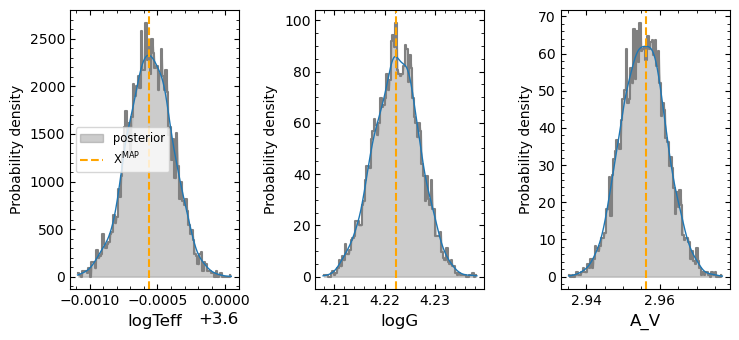

In [16]:
map_values = exp.calculate_map(post_list[0], c, plot=True) # plot default = False
# by plot=True, you can check if MAP is well calculated.
# it will show posterior distribution (grey), gaussina KDE (blue curve), calculated MAP (orange)

In [17]:
map_list = []
unc_list = []
for post in post_list:
    map_list.append( exp.calculate_map(post, c) )
    unc_list.append( exp.calculate_uncertainty(post, c, confidence=68, percent=True, add_Teff=True) )
map_list = np.array(map_list)
unc_list = np.array(unc_list)

### Simple 1D posterior distribution plot

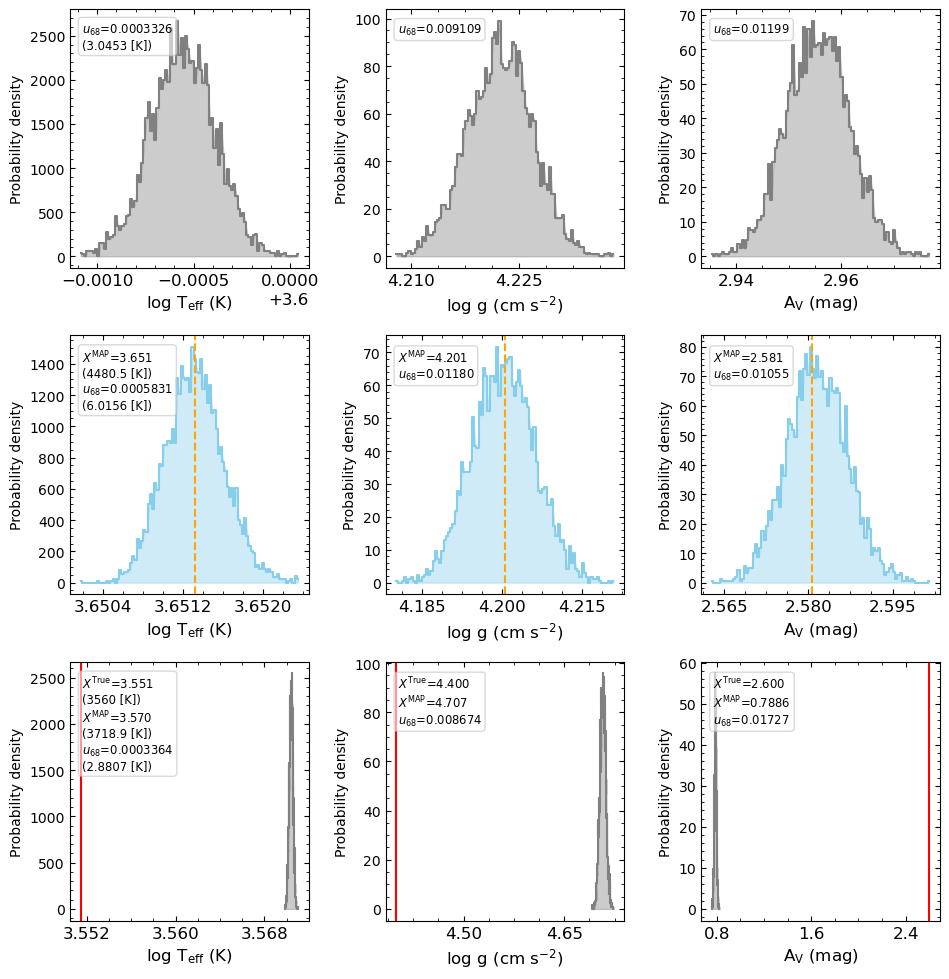

In [18]:
# you can check usable keywords in expander.py

# kwarg = dict(nbin=100, # number of bin to make histrogram
#     color_post = 'grey', xlabelsize='large', ylabelsize='large', titlesize='x-large',
#     yticklabelsize='medium', xticklabelsize='large', txtsize = 'small',
#     u68_values=u68, map_values=maps, plot_map=False)

fig, axis = plt.subplots(3, c.x_dim, figsize=[3.2*c.x_dim, 3.3*3], tight_layout=True)

# first target
exp.plot_posterior(post_list[0], axis[0], c) # only with defualt kwarg setting
# second target
exp.plot_posterior(post_list[1], axis[1], c, map_values=map_list[1], u68_values=unc_list[1], color_post='skyblue')
# third target
exp.plot_posterior(post_list[2], axis[2], c, map_values=map_list[2], u68_values=unc_list[2], plot_map=False,
                  x_true=[3.5514499979728753, 4.4,  2.599609375])

## Use Noise-Net (SpD_TGARL_Noise_mMUSE)
You need both flux and flux error of the observaiton.
Our current Noise-Net is SpD_TGARL_Noise_mMUSE

- Settl + Dusty library
- Noise-Net (c.prenoise_training = True)
- T: 2600~7000
- g: 2.5 ~ 5
- Av: 0 ~ 10 (random sampling during training) + f_min = 0.1
- r: 0 ~ 2 (random sampling during tarining)  + f_min = 0.5
- library : 0=Settl, 1=Dusty
- use the entire MUSE range but exclude masked regions (emission lines)

In [19]:
# Read network
net_dir = '../networks/SpD_TGARL_Noise_mMUSE/'
config_file = 'c_SpD_TGARL_Noise_mMUSE.py'

c = read_config_from_file( net_dir + config_file, proj_dir = net_dir)
print('c.prenoise_training:',c.prenoise_training) # Noise-Net
c.device = 'cpu'
print(c.device)


c.prenoise_training: True
cpu


### Prepare observations

In [20]:
# Read example spectra in examples/Tr14_spec/
# flux is in physical unit
spec_array = []
for file in sorted(glob.glob('Tr14_spec/*.dat')):
    spec_array.append(np.loadtxt(file))
spec_array = np.array(spec_array)

# 0) Read error of example spectra (in physical unit)
# Noise-Net does not use physical error but use fractional error, sigma = flux_error/flux
sigma_array = spec_array.copy()*0.0
for i, efile in enumerate( sorted(glob.glob('Tr14_spec_error/*.dat')) ):
    yerr = np.loadtxt(efile)
    ymin = np.nanmin(abs(spec_array[i]))
    sigma_array[i] = yerr / np.clip(spec_array[i], a_min=ymin, a_max=None) # to avoid using negative values


# 1) you need to reduce the dimension corresponding to the network (i.e. exluding emission lines)
#-------------------- Reduce observation/sigma dimension equal to y_names ----------------------------
y_table = Table(spec_array, names=['l{:d}'.format(i) for i in range(0, 3681)]) # MUSE full range
y_table = y_table[c.y_names]
obs_array = np.array(y_table).view(float).reshape(len(y_table), -1)

# also reduce dimensiont of sigma array
s_table = Table(sigma_array, names=['l{:d}'.format(i) for i in range(0, 3681)])
s_table = s_table[c.y_names]
sig_array = np.array(s_table).view(float).reshape(len(s_table), -1) 

# [Suggestion]: if you use real data, you'd better avoid negative values (also, you must avoid nan values)
# for physical unit: clip to 0 flux
obs_array = np.clip(obs_array, a_min=0, a_max=None)

# 2) Normalize spectrum by the total flux
# because this network used normalized flux
print('c.normalize_flux:',c.normalize_flux)
print('c.normalize_total_flux:',c.normalize_total_flux)

# simply you can normalize flux by yourself
# > obs_array = obs_array/np.sum(obs_array, axis=1).reshape(-1,1) 

# or you can use exp
if c.normalize_flux:
    obs_array = exp.normalize_flux(obs_array, normalize_total_flux=c.normalize_total_flux, 
                       normalize_mean_flux=c.normalize_mean_flux, normalize_f750=c.normalize_f750)
    
# In the case of SpD_TGARL_Noise_mMUSE, we trained on a single value error per model.
# You can use either all sigma values per observation or change values to median
sig_array = np.repeat(np.median(sig_array, axis=1).reshape(-1,1), obs_array.shape[1], axis=1)

c.normalize_flux: True
c.normalize_total_flux: True


### Get poseterior

In [21]:
# In Noise-Net, you give sigma (in linear scale, not in percent unit) as unc
post_list  = exp.get_posterior(obs_array, c, N=4096, unc=sig_array,
                               use_group=True, group=3) # target x N_pred x N_param
# group option is usable when you deal with many observations
# use_group=False : calculate posteriors one by one by for loop
# use_group=True : calculate posteriors of multiple observations once 
# >> heavier calculation, but less loop. Useful when you use GPU. If you use CPU, not necessary
# group = number of observations to caluclate at once
# >> if group is too large, it may raise memory issue! 

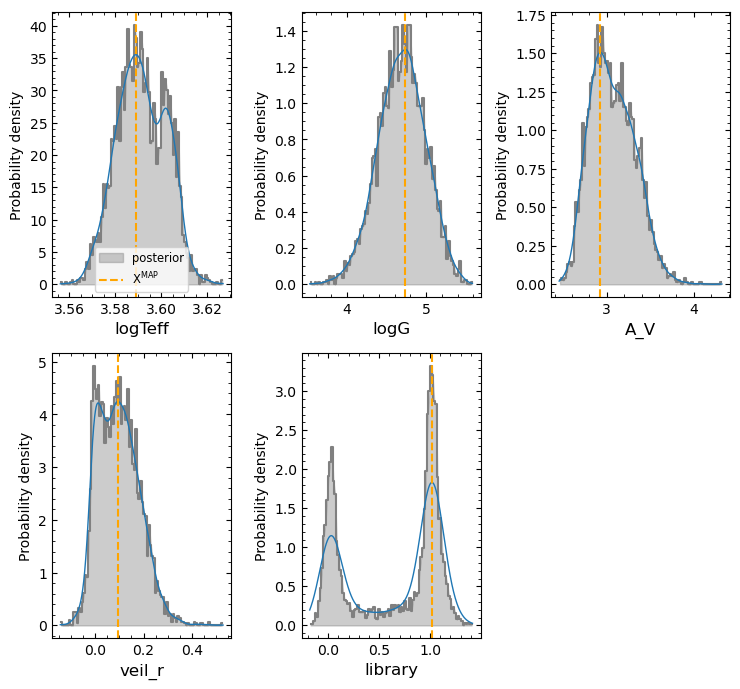

In [22]:
map_values = exp.calculate_map(post_list[0], c, plot=True) # plot default = False
# by plot=True, you can check if MAP is well calculated.

In [23]:
map_list = []
unc_list = []
for post in post_list:
    map_list.append( exp.calculate_map(post, c) )
    unc_list.append( exp.calculate_uncertainty(post, c, confidence=68, percent=True, add_Teff=True) )
map_list = np.array(map_list)
unc_list = np.array(unc_list)

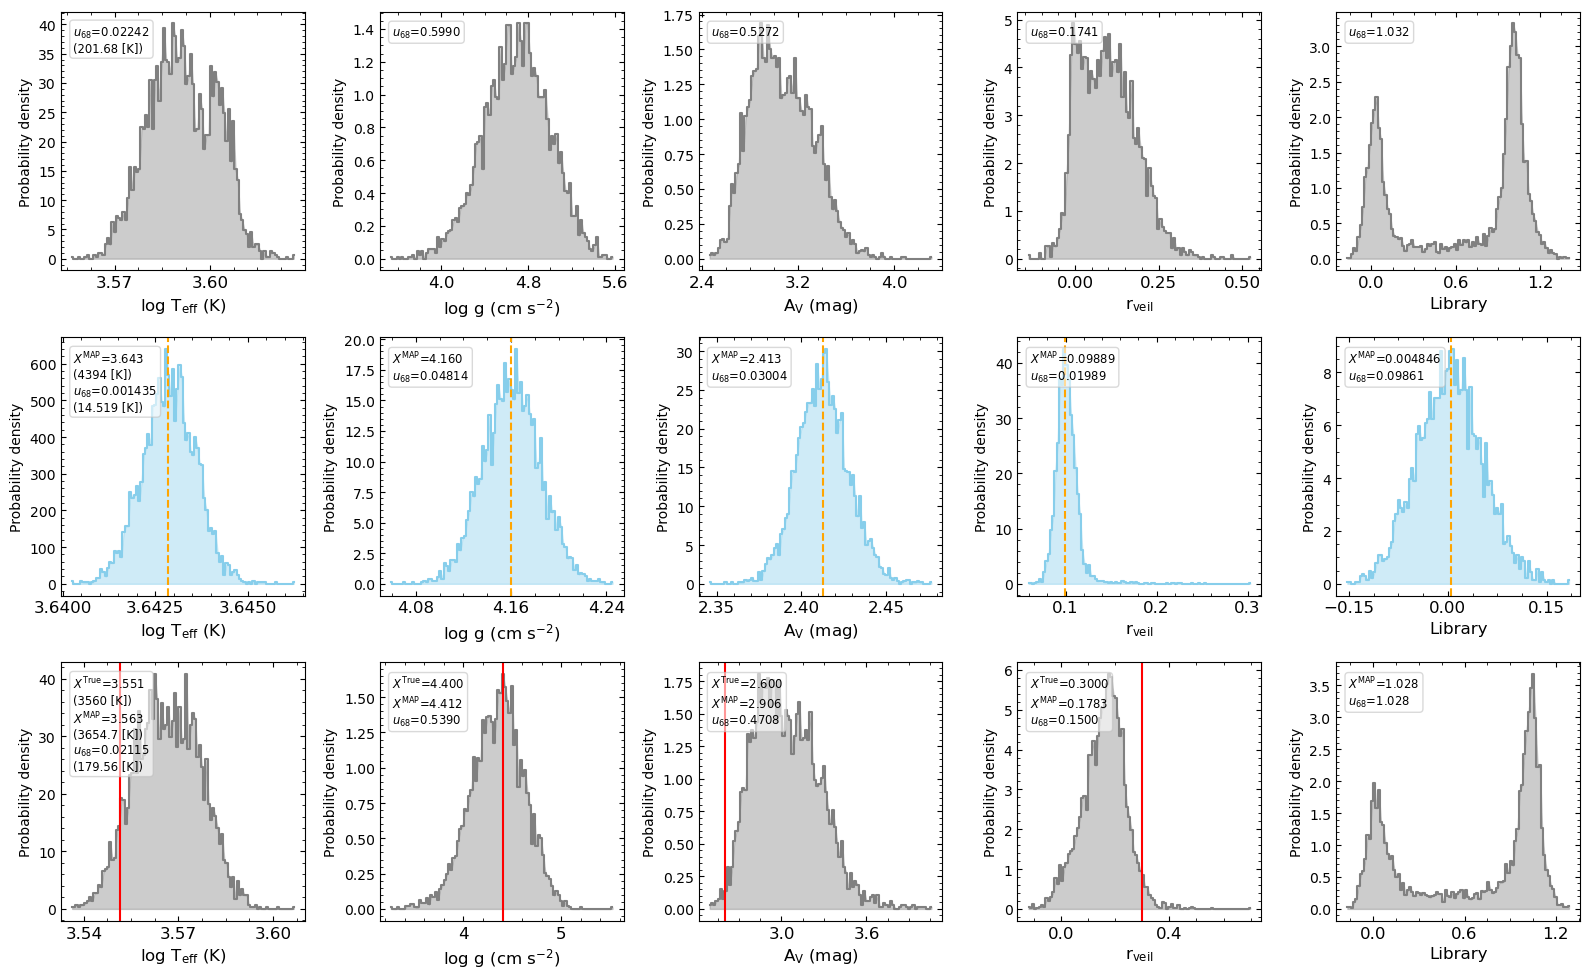

In [24]:
# you can check usable keywords in expander.py

# kwarg = dict(nbin=100, # number of bin to make histrogram
#     color_post = 'grey', xlabelsize='large', ylabelsize='large', titlesize='x-large',
#     yticklabelsize='medium', xticklabelsize='large', txtsize = 'small',
#     u68_values=u68, map_values=maps, plot_map=False)

fig, axis = plt.subplots(3, c.x_dim, figsize=[3.2*c.x_dim, 3.3*3], tight_layout=True)

# first target
exp.plot_posterior(post_list[0], axis[0], c) # only with defualt kwarg setting
# second target
exp.plot_posterior(post_list[1], axis[1], c, map_values=map_list[1], u68_values=unc_list[1], color_post='skyblue')
# third target
exp.plot_posterior(post_list[2], axis[2], c, map_values=map_list[2], u68_values=unc_list[2], plot_map=False,
                  x_true=[3.5514499979728753, 4.4,  2.599609375, 0.300048828125, np.nan])